In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from pyod.models.knn import KNN 

from sklearn.feature_selection import( 
    RFECV,
    SequentialFeatureSelector,
    SelectFromModel
)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import(
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from src.wrapped import Wrapped
from src.analyses import graphic_anomalies
from src.train import cross_validate_balancead, train_feature_combination

In [3]:
wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importando dados para treinamento

In [4]:
df = wp.load_data('df_instrumentos_features_selecionadas')

# instrumentos de sopro:
inst_sopro = ["clarinet", "trombone", "flute", "trumpet", "saxophone"]
df = df[df['instrumento'].isin(inst_sopro)]

- Definindo as variaveis de treino e o target

In [5]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df.instrumento)

In [6]:
X = df.drop(columns=['labels', 'instrumento','file_name'])
y = df['labels'].to_frame()

# TESTE 1: Balanceamento

- 1° Opção: Balanceamento das classes com SMOTH

In [7]:
t1_models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t1_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X, y=y, oversampling=True) for model in t1_models]

dict_results_t1 = {
    'Naive Bayes': t1_acuracy_models[0],
    'KNN': t1_acuracy_models[1],
    'Arvore de Decisão': t1_acuracy_models[2],
    'Floresta Aleatoria': t1_acuracy_models[3],
    'HistGradientBoosting': t1_acuracy_models[4],
    'LIGHTGBM': t1_acuracy_models[5],
    'MLP': t1_acuracy_models[6],
    'SVC': t1_acuracy_models[7],
}

dict_results_t1

Acuracia do modelo GaussianNB() do Fold 0: 0.5279503105590062
Acuracia do modelo GaussianNB() do Fold 1: 0.5714285714285714
Acuracia do modelo GaussianNB() do Fold 2: 0.5652173913043478
Acuracia do modelo GaussianNB() do Fold 3: 0.5434782608695652
Acuracia do modelo GaussianNB() do Fold 4: 0.5981308411214953
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.35403726708074534
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.3385093167701863
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.37577639751552794
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.3416149068322981
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.3925233644859813
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.43478260869565216
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5279503105590062
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5093167701863354
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.4751552795031056
Acuracia do modelo DecisionTree

{'Naive Bayes': 0.5612410750565973,
 'KNN': 0.36049225053694783,
 'Arvore de Decisão': 0.49162167914707533,
 'Floresta Aleatoria': 0.6762214353437433,
 'HistGradientBoosting': 0.6960952767941797,
 'LIGHTGBM': 0.7016834039589017,
 'MLP': 0.43497223350941355,
 'SVC': 0.3238095238095238}

- 2° Opção: Class Weight

In [8]:
models_class_weight = np.array([
    DecisionTreeClassifier(class_weight='balanced'), 
    RandomForestClassifier(class_weight='balanced', random_state = 0, n_jobs = -1), 
    LGBMClassifier(class_weight='balanced'),
])

t1_acuracy_models_class_weight = [cross_validate_balancead(k=5, model=model, X=X, y=y, weight=True) for model in models_class_weight]

dict_results_t1_class_weight = {
    'Arvore de Decisão': t1_acuracy_models_class_weight[0],
    'Floresta Aleatoria': t1_acuracy_models_class_weight[1],
    'LIGHTGBM': t1_acuracy_models_class_weight[2],
}

dict_results_t1_class_weight

Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 0: 0.5279503105590062
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 1: 0.5093167701863354
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 2: 0.5186335403726708
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 3: 0.5186335403726708
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 4: 0.48598130841121495
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 0: 0.6832298136645962
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 1: 0.7018633540372671
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 2: 0.7204968944099379
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 3: 0.6801242236024845
Acuracia do modelo

{'Arvore de Decisão': 0.5121030939803797,
 'Floresta Aleatoria': 0.7054294615042278,
 'LIGHTGBM': 0.7066736324761518}

# TESTE 2: Remover Outlier

- Treinar modelo de classificação de outilier

In [7]:
detector_outilier = KNN()

new_df = df.drop(columns=['instrumento','file_name'])

detector_outilier.fit(new_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

- Checar numeros de outilers e não outilers<br/>
**0 (False) Não é outiler**<br/>
**1 (True) É outiler**

In [8]:
previsions = detector_outilier.labels_
np.unique(previsions, return_counts=True)

(array([0, 1]), array([1448,  161]))

- Distancia euclidiana dos registros

In [9]:
confiance_previsions = detector_outilier.decision_scores_
confiance_previsions

array([ 573.28682546, 1165.41972437,  529.69517971, ...,  750.32724957,
        748.97427048,  424.90582813])

- Checar os outilers

In [10]:
# pegando indice dos registros que são outilers
outilers_id = [previsions[i] == 1 for i in range(previsions.shape[0])]
outilers = df.iloc[outilers_id,:]
outilers

tonnetz0  tonnetz1   chroma1  ...  instrumento          file_name  labels
1876 -0.044667  0.260524  0.692127  ...     clarinet  001020_395520.ogg       0
1878  0.089747  0.253008  0.299878  ...     clarinet  001563_195840.ogg       0
1886  0.002779  0.015584  0.311722  ...     clarinet  009170_188160.ogg       0
1888  0.108679  0.066236  0.484411  ...     clarinet  009884_138240.ogg       0
1897  0.040330  0.013987  0.226904  ...     clarinet  015674_115200.ogg       0
...        ...       ...       ...  ...          ...                ...     ...
7151 -0.215709  0.074658  0.095596  ...      trumpet   120220_76800.ogg       4
7153  0.095131  0.165130  0.409808  ...      trumpet   125119_11520.ogg       4
7156 -0.148693  0.003055  0.543909  ...      trumpet  130811_399360.ogg       4
7159 -0.040215  0.031151  0.587902  ...      trumpet  138998_691200.ogg       4
7160  0.010755  0.116696  0.688803  ...      trumpet   138999_76800.ogg       4

[161 rows x 47 columns]

In [11]:
outilers.instrumento.value_counts()

flute        103
clarinet      20
saxophone     19
trumpet       10
trombone       9
Name: instrumento, dtype: int64

- grafico 

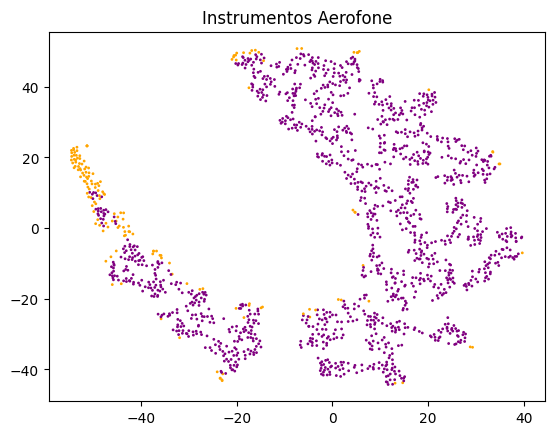

In [12]:
graphic_anomalies(df.drop(columns=['instrumento','file_name']), 'Instrumentos Aerofone')

- Agora vamos remover os outilers da nossa base

In [13]:
# pegando indice dos registros que não são outilers
outilers_id =[previsions[i] == 0 for i in range(previsions.shape[0])]
df_train = df.iloc[outilers_id,:]
df_train

tonnetz0  tonnetz1   chroma1  ...  instrumento          file_name  labels
1875  0.060383  0.017910  0.319152  ...     clarinet   000726_72960.ogg       0
1877 -0.102407 -0.053821  0.007352  ...     clarinet  001210_184320.ogg       0
1879  0.137429 -0.165245  0.004996  ...     clarinet  001630_134400.ogg       0
1880  0.236781 -0.104811  0.360671  ...     clarinet       003872_0.ogg       0
1881  0.251144  0.276060  0.757470  ...     clarinet   005201_99840.ogg       0
...        ...       ...       ...  ...          ...                ...     ...
7161  0.031326  0.036042  0.281165  ...      trumpet  141573_157440.ogg       4
7162  0.024069 -0.064162  0.038717  ...      trumpet   149060_46080.ogg       4
7163  0.046916  0.068088  0.517141  ...      trumpet   149506_92160.ogg       4
7164  0.109233  0.002179  0.271734  ...      trumpet  150659_195840.ogg       4
7165  0.143650  0.051470  0.110378  ...      trumpet  154048_192000.ogg       4

[1448 rows x 47 columns]

- Treinar modelos sem outlier e balanceameto

In [15]:
X_rm_outilers = df_train.drop(columns=['labels', 'instrumento','file_name'])
y_rm_outilers = df_train['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t2_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X_rm_outilers,  y=y_rm_outilers) for model in models]

dict_results_t2 = {
    'Naive Bayes': t2_acuracy_models[0],
    'KNN': t2_acuracy_models[1],
    'Arvore de Decisão': t2_acuracy_models[2],
    'Floresta Aleatoria': t2_acuracy_models[3],
    'HistGradientBoosting': t2_acuracy_models[4],
    'LIGHTGBM': t2_acuracy_models[5],
    'MLP': t2_acuracy_models[6],
    'SVC': t2_acuracy_models[7],
}

dict_results_t2

Acuracia do modelo GaussianNB() do Fold 0: 0.5379310344827586
Acuracia do modelo GaussianNB() do Fold 1: 0.6448275862068965
Acuracia do modelo GaussianNB() do Fold 2: 0.596551724137931
Acuracia do modelo GaussianNB() do Fold 3: 0.5847750865051903
Acuracia do modelo GaussianNB() do Fold 4: 0.6332179930795848
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.4517241379310345
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4862068965517241
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.47750865051903113
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5363321799307958
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5310344827586206
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5413793103448276
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5724137931034483
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5501730103806228
Acuracia do modelo DecisionTreeClassifier() do Fo

{'Naive Bayes': 0.5994606848824723,
 'KNN': 0.4903543729865172,
 'Arvore de Decisão': 0.5552630950960505,
 'Floresta Aleatoria': 0.7134017420355567,
 'HistGradientBoosting': 0.7023553275265482,
 'LIGHTGBM': 0.7161651354253669,
 'MLP': 0.4765564968380862,
 'SVC': 0.5145090084715427}

# TESTE 3: Features de Maior Correlação

In [18]:
df_corr = df.drop(columns=['instrumento', 'file_name', 'labels']).corr().unstack().reset_index().dropna()
df_corr.rename(
    columns = {'level_0': 'features_a', 'level_1': 'features_b', 0:'correlacao'}, 
    inplace = True)
df_corr

features_a          features_b  correlacao
0          tonnetz0            tonnetz0    1.000000
1          tonnetz0            tonnetz1    0.099321
2          tonnetz0             chroma1   -0.063724
3          tonnetz0             chroma2   -0.161056
4          tonnetz0             chroma3    0.216762
...             ...                 ...         ...
1931  zero_crossing    spectral_rolloff    0.662313
1932  zero_crossing          spectogram   -0.098559
1933  zero_crossing      mel_spectogram   -0.124501
1934  zero_crossing  zero_crossing_rate    0.999999
1935  zero_crossing       zero_crossing    1.000000

[1936 rows x 3 columns]

- Correlação Positia

In [19]:
corr_posit = df_corr.query('correlacao > 0.5 and correlacao < 1.0')
corr_posit

features_a          features_b  correlacao
271              chroma5             chroma6    0.502817
314              chroma6             chroma5    0.502817
430                mfcc0      spectral_band2    0.525263
435                mfcc0    spectral_rolloff    0.506348
631                mfcc5               mfcc6    0.535504
...                  ...                 ...         ...
1887  zero_crossing_rate    spectral_rolloff    0.662260
1891  zero_crossing_rate       zero_crossing    0.999999
1929       zero_crossing   spectral_centroid    0.826812
1931       zero_crossing    spectral_rolloff    0.662313
1934       zero_crossing  zero_crossing_rate    0.999999

[64 rows x 3 columns]

In [20]:
corr_posit.features_a.unique(), len(corr_posit.features_a.unique())

(array(['chroma5', 'chroma6', 'mfcc0', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
        'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14',
        'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'chroma9', 'chroma10',
        'chroma11', 'spectral_band2', 'spectral_band3', 'spectral_band4',
        'spectral_centroid', 'spectral_rolloff', 'spectogram',
        'mel_spectogram', 'zero_crossing_rate', 'zero_crossing'],
       dtype=object),
 29)

In [10]:
X =  df[corr_posit.features_a.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_posit = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_posit = {
    'Naive Bayes': t3_acuracy_models_corr_posit[0],
    'KNN': t3_acuracy_models_corr_posit[1],
    'Arvore de Decisão': t3_acuracy_models_corr_posit[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_posit[3],
    'HistGradientBoosting': t3_acuracy_models_corr_posit[4],
    'LIGHTGBM': t3_acuracy_models_corr_posit[5],
    'XGB': t3_acuracy_models_corr_posit[6],
    'MLP': t3_acuracy_models_corr_posit[7],
    'SVC': t3_acuracy_models_corr_posit[8],
}

dict_results_t3_corr_posit

Acuracia do modelo GaussianNB() do Fold 0: 0.5590062111801242
Acuracia do modelo GaussianNB() do Fold 1: 0.6024844720496895
Acuracia do modelo GaussianNB() do Fold 2: 0.5838509316770186
Acuracia do modelo GaussianNB() do Fold 3: 0.5807453416149069
Acuracia do modelo GaussianNB() do Fold 4: 0.6230529595015576
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.468944099378882
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4782608695652174
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5124223602484472
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4813664596273292
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5389408099688473
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.4968944099378882
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.4658385093167702
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5217391304347826
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.515527950310559
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.5898279832046593,
 'KNN': 0.4959869197577446,
 'Arvore de Decisão': 0.5028037383177569,
 'Floresta Aleatoria': 0.6731023006520772,
 'HistGradientBoosting': 0.6762233702908226,
 'LIGHTGBM': 0.6774656063156673,
 'XGB': 0.6637835955186626,
 'MLP': 0.39971169288519964,
 'SVC': 0.5109034267912772}

- Correlação Negativa

In [11]:
corr_negat = df_corr.query('correlacao > -1.0 and correlacao < -0.5')
corr_negat

features_a          features_b  correlacao
474                mfcc1      spectral_band2   -0.798403
475                mfcc1      spectral_band3   -0.745708
476                mfcc1      spectral_band4   -0.666942
477                mfcc1   spectral_centroid   -0.861014
479                mfcc1    spectral_rolloff   -0.831580
482                mfcc1  zero_crossing_rate   -0.621754
483                mfcc1       zero_crossing   -0.621826
1506      spectral_band2               mfcc1   -0.798403
1550      spectral_band3               mfcc1   -0.745708
1594      spectral_band4               mfcc1   -0.666942
1638   spectral_centroid               mfcc1   -0.861014
1726    spectral_rolloff               mfcc1   -0.831580
1858  zero_crossing_rate               mfcc1   -0.621754
1902       zero_crossing               mfcc1   -0.621826

In [21]:
X =  df[corr_negat.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_neg = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_neg = {
    'Naive Bayes': t3_acuracy_models_corr_neg[0],
    'KNN': t3_acuracy_models_corr_neg[1],
    'Arvore de Decisão': t3_acuracy_models_corr_neg[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_neg[3],
    'HistGradientBoosting': t3_acuracy_models_corr_neg[4],
    'LIGHTGBM': t3_acuracy_models_corr_neg[5],
    'XGB': t3_acuracy_models_corr_neg[6],
    'MLP': t3_acuracy_models_corr_neg[7],
    'SVC': t3_acuracy_models_corr_neg[8],
}

dict_results_t3_corr_neg

Acuracia do modelo GaussianNB() do Fold 0: 0.43478260869565216
Acuracia do modelo GaussianNB() do Fold 1: 0.484472049689441
Acuracia do modelo GaussianNB() do Fold 2: 0.4813664596273292
Acuracia do modelo GaussianNB() do Fold 3: 0.468944099378882
Acuracia do modelo GaussianNB() do Fold 4: 0.48286604361370716
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.4658385093167702
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4782608695652174
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5031055900621118
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4813664596273292
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5420560747663551
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.4782608695652174
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.45652173913043476
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.4813664596273292
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.48757763975155277
Acuracia do modelo DecisionTreeC

{'Naive Bayes': 0.4704862522010023,
 'KNN': 0.4941255006675568,
 'Arvore de Decisão': 0.47358023258063897,
 'Floresta Aleatoria': 0.5929355082138503,
 'HistGradientBoosting': 0.5805208877537199,
 'LIGHTGBM': 0.5873473810491283,
 'XGB': 0.5798842901646639,
 'MLP': 0.41579884290164665,
 'SVC': 0.509655385925195}

- Se combinarmos as duas abordagens ?

In [14]:
features = np.append(corr_posit.features_b.values, corr_negat.features_b.values)
features = np.unique(features)

X = df[features]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_combine_corr = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_cb = {
    'Naive Bayes': t3_combine_corr[0],
    'KNN': t3_combine_corr[1],
    'Arvore de Decisão': t3_combine_corr[2],
    'Floresta Aleatoria': t3_combine_corr[3],
    'HistGradientBoosting': t3_combine_corr[4],
    'LIGHTGBM': t3_combine_corr[5],
    'XGB': t3_combine_corr[6],
    'MLP': t3_combine_corr[7],
    'SVC': t3_combine_corr[8],
}

dict_results_t3_cb

Acuracia do modelo GaussianNB() do Fold 0: 0.5434782608695652
Acuracia do modelo GaussianNB() do Fold 1: 0.6118012422360248
Acuracia do modelo GaussianNB() do Fold 2: 0.577639751552795
Acuracia do modelo GaussianNB() do Fold 3: 0.5807453416149069
Acuracia do modelo GaussianNB() do Fold 4: 0.6199376947040498
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.468944099378882
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4751552795031056
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5093167701863354
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4813664596273292
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5389408099688473
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.484472049689441
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.515527950310559
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.546583850931677
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.4906832298136646
Acuracia do modelo DecisionTreeClassifi

{'Naive Bayes': 0.5867204581954683,
 'KNN': 0.4947446837328998,
 'Arvore de Decisão': 0.5102571544668254,
 'Floresta Aleatoria': 0.6768328786207698,
 'HistGradientBoosting': 0.6929954915733055,
 'LIGHTGBM': 0.6898918364582729,
 'XGB': 0.6892591087633754,
 'MLP': 0.5034055068593875,
 'SVC': 0.5115245448036996}

- Correlação de -0.5 a 0.5

In [15]:
corr_prox_zero = df_corr.query('correlacao > -0.5 and correlacao < 0.5')
corr_prox_zero

features_a      features_b  correlacao
1          tonnetz0        tonnetz1    0.099321
2          tonnetz0         chroma1   -0.063724
3          tonnetz0         chroma2   -0.161056
4          tonnetz0         chroma3    0.216762
5          tonnetz0         chroma4   -0.186788
...             ...             ...         ...
1927  zero_crossing  spectral_band3    0.323640
1928  zero_crossing  spectral_band4    0.211614
1930  zero_crossing  spectral_onset    0.215827
1932  zero_crossing      spectogram   -0.098559
1933  zero_crossing  mel_spectogram   -0.124501

[1814 rows x 3 columns]

In [17]:
len(corr_prox_zero.features_b.unique())

44

In [16]:
X =  df[corr_prox_zero.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_prox_zero = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr = {
    'Naive Bayes': t3_acuracy_models_corr_prox_zero[0],
    'KNN': t3_acuracy_models_corr_prox_zero[1],
    'Arvore de Decisão': t3_acuracy_models_corr_prox_zero[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_prox_zero[3],
    'HistGradientBoosting': t3_acuracy_models_corr_prox_zero[4],
    'LIGHTGBM': t3_acuracy_models_corr_prox_zero[5],
    'XGB': t3_acuracy_models_corr_prox_zero[6],
    'MLP': t3_acuracy_models_corr_prox_zero[7],
    'SVC': t3_acuracy_models_corr_prox_zero[8],
}

dict_results_t3_corr

Acuracia do modelo GaussianNB() do Fold 0: 0.5590062111801242
Acuracia do modelo GaussianNB() do Fold 1: 0.6428571428571429
Acuracia do modelo GaussianNB() do Fold 2: 0.5993788819875776
Acuracia do modelo GaussianNB() do Fold 3: 0.5962732919254659
Acuracia do modelo GaussianNB() do Fold 4: 0.6230529595015576
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.468944099378882
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4782608695652174
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5093167701863354
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4813664596273292
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.5389408099688473
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5217391304347826
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.546583850931677
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5559006211180124
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5279503105590062
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.6041136974903736,
 'KNN': 0.4953658017453222,
 'Arvore de Decisão': 0.5295002031694434,
 'Floresta Aleatoria': 0.7041814206381455,
 'HistGradientBoosting': 0.7072889456473366,
 'LIGHTGBM': 0.709773417697026,
 'XGB': 0.7128790077591378,
 'MLP': 0.5829898802267758,
 'SVC': 0.5102803738317757}

# TESTE4: Recursive Feature Elimination - (RFE)

- RFE

In [24]:
X = df.drop(columns=['instrumento','file_name','labels'])
y = df['labels'].to_frame()

clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)
                               
                               
estimators = RFECV(estimator=clf, scoring='accuracy', cv=5)

# fit rfecv
rfecv_data = estimators.fit(X, y)

# gorresponde à posição do ranking do i-ésimo recurso
ranking_features = rfecv_data.ranking_

# A máscara dos recursos selecionados.
support_features = rfecv_data.support_

# filtro
features_selects = X.columns[support_features]

In [25]:
features_selects

Index(['chroma2', 'chroma6', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc7', 'mfcc8', 'mfcc10', 'mfcc16', 'mfcc18', 'spectral_band2',
       'spectral_onset', 'zero_crossing_rate'],
      dtype='object')

In [26]:
ranking_features.shape

(44,)

- Count Ranking Features

In [27]:
# Couts da features import 
unique, frequency = np.unique(ranking_features, return_counts=True)
summary = np.asarray((unique, frequency)).T
summary

array([[ 1, 15],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1],
       [ 6,  1],
       [ 7,  1],
       [ 8,  1],
       [ 9,  1],
       [10,  1],
       [11,  1],
       [12,  1],
       [13,  1],
       [14,  1],
       [15,  1],
       [16,  1],
       [17,  1],
       [18,  1],
       [19,  1],
       [20,  1],
       [21,  1],
       [22,  1],
       [23,  1],
       [24,  1],
       [25,  1],
       [26,  1],
       [27,  1],
       [28,  1],
       [29,  1],
       [30,  1]])

- Treinamento de Modelo

In [28]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t4_acuracy_models = [cross_validate_balancead(k=5, 
                                              model=model,
                                              X=X, 
                                              y=y, 
                                              oversampling=True) for model in models]

dict_results_t4 = {
    'Naive Bayes': t4_acuracy_models[0],
    'KNN': t4_acuracy_models[1],
    'Arvore de Decisão': t4_acuracy_models[2],
    'Floresta Aleatoria': t4_acuracy_models[3],
    'HistGradientBoosting': t4_acuracy_models[4],
    'LIGHTGBM': t4_acuracy_models[5],
    'XGB': t4_acuracy_models[6],
    'MLP': t4_acuracy_models[7],
    'SVC': t4_acuracy_models[8],
}

dict_results_t4

Acuracia do modelo GaussianNB() do Fold 0: 0.5279503105590062
Acuracia do modelo GaussianNB() do Fold 1: 0.5714285714285714
Acuracia do modelo GaussianNB() do Fold 2: 0.5652173913043478
Acuracia do modelo GaussianNB() do Fold 3: 0.5434782608695652
Acuracia do modelo GaussianNB() do Fold 4: 0.5981308411214953
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.35403726708074534
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.3385093167701863
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.37577639751552794
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.3416149068322981
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.3925233644859813
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.453416149068323
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.515527950310559
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.515527950310559
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.45962732919254656
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.5612410750565973,
 'KNN': 0.36049225053694783,
 'Arvore de Decisão': 0.4916236140941545,
 'Floresta Aleatoria': 0.669385267312939,
 'HistGradientBoosting': 0.6960952767941797,
 'LIGHTGBM': 0.7016834039589017,
 'XGB': 0.6787155821288288,
 'MLP': 0.4380101004237534,
 'SVC': 0.3238095238095238}

# Teste 5: SequentialFeatureSelector

### Forward

In [29]:
def selectorSequential(k, model_estimator, n_features, X, y):
    sfs = SequentialFeatureSelector(
        cv=k, 
        # direction = 'forward',
        n_features_to_select = n_features,
        estimator=model_estimator
    ).fit(X, y)
    
    mask_feature = sfs.get_support()
    
    return X[X.columns[mask_feature]]

In [43]:
_X = selectorSequential(5, DecisionTreeClassifier(), 20, X, y)
_X 

tonnetz0   chroma1   chroma5       mfcc1      mfcc3      mfcc7  \
1875  0.060383  0.319152  0.357706   97.471786  17.726433   6.797719   
1876 -0.044667  0.692127  0.732275   61.911442   5.291811  -8.966903   
1877 -0.102407  0.007352  0.649991  107.638947  19.598055   6.002571   
1878  0.089747  0.299878  0.079692  120.258324  33.841656   8.346146   
1879  0.137429  0.004996  1.000000  123.996521  17.919901   2.746356   
...        ...       ...       ...         ...        ...        ...   
7161  0.031326  0.281165  0.358991  206.371201  31.268805   4.466880   
7162  0.024069  0.038717  0.865360  157.358063 -22.252892  -6.040964   
7163  0.046916  0.517141  0.516097   87.706017  19.628988  13.540272   
7164  0.109233  0.271734  0.266866   85.668198  27.054415   7.659579   
7165  0.143650  0.110378  0.238701  116.189003  27.092890   7.463788   

          mfcc8     mfcc10     mfcc11     mfcc12    mfcc13     mfcc14  \
1875 -12.122009  -5.698319  -4.186620  -9.178421 -1.513219  -7.577986   
1876 -17.932789  -0.170921  -4.303693 -22.350485 -7.793060  -8.507512   
1877   0.851709 -19.618681 -17.366951 -20.012222 -7.600814  -7.568542   
1878 -18.452084 -17.178339  13.240421   7.321417 -0.485359 -17.735708   
1879 -12.056657  -8.135055 -11.603746 -14.456120 -9.266733 -11.163033   
...         ...        ...        ...        ...       ...        ...   
7161   5.603338  -0.550061  -0.846498   3.068826  0.369699   3.024948   
7162  -9.734241   1.526627  22.664223  11.602703  3.469329 -10.473911   
7163  -1.963343  -4.630041  -0.351327  -0.043541  5.902341  -8.385210   
7164  -4.940868  -9.414302  -6.928515  -8.427592  0.066050  -0.314506   
7165  -2.065419   2.762986   6.799120  -3.949550 -0.437244  -3.611916   

         mfcc18     mfcc19   chroma9  spectral_centroid  spectral_rolloff  \
1875  -6.443947  -0.662083  0.303745        2328.546611       5092.952266   
1876 -23.979158 -16.185549  0.131283        1872.058375       2738.513835   
1877  -7.859767  -5.318481  0.012319        1571.665681       3635.089465   
1878  11.148084  -0.458791  0.157988        1999.856294       3282.789275   
1879  -0.551916   6.183865  0.006446        1302.617113       2510.017073   
...         ...        ...       ...                ...               ...   
7161  -2.675308  -1.034018  0.503876         896.653459       1782.859289   
7162  -3.939756 -15.273481  0.073563        1280.731144       1930.644010   
7163   1.184325   5.494852  0.560932        2309.708871       5199.019529   
7164  -5.837808  -1.235146  0.468994        2370.998419       5153.205266   
7165  -1.258389   1.228507  0.213860        1835.735303       3431.498276   

      mel_spectogram  zero_crossing_rate  zero_crossing  
1875      -68.585281            0.105613          23362  
1876      -80.000000            0.139929          30932  
1877      -78.551147            0.036253           8015  
1878      -71.021973            0.176906          39102  
1879      -77.810928            0.029619           6548  
...              ...                 ...            ...  
7161      -42.830780            0.041767           9231  
7162      -79.643761            0.078466          17360  
7163      -57.435429            0.095421          21114  
7164      -79.120621            0.126226          27933  
7165      -42.306446            0.093954          20772  

[1609 rows x 20 columns]

In [44]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t5_acuracy_models = [cross_validate_balancead(k=5, model=model, X=_X, y=y) for model in models]

dict_results_t5 = {
    'Naive Bayes':t5_acuracy_models[0],
    'KNN':t5_acuracy_models[1],
    'Arvore de Decisão': t5_acuracy_models[2],
    'Floresta Aleatoria':t5_acuracy_models[3],
    'HistGradientBoosting':t5_acuracy_models[4],
    'LIGHTGBM': t5_acuracy_models[5],
    'XGB': t5_acuracy_models[6],
    'MLP': t5_acuracy_models[7],
    'SVC': t5_acuracy_models[8],
}

dict_results_t5

Acuracia do modelo GaussianNB() do Fold 0: 0.5745341614906833
Acuracia do modelo GaussianNB() do Fold 1: 0.6273291925465838
Acuracia do modelo GaussianNB() do Fold 2: 0.6024844720496895
Acuracia do modelo GaussianNB() do Fold 3: 0.5838509316770186
Acuracia do modelo GaussianNB() do Fold 4: 0.632398753894081
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.46273291925465837
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.4472049689440994
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.4751552795031056
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.4984423676012461
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.562111801242236
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5807453416149069
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.577639751552795
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6304347826086957
Acuracia do modelo DecisionTreeClassifier() do Fold

{'Naive Bayes': 0.6041195023316112,
 'KNN': 0.4767071070606219,
 'Arvore de Decisão': 0.5842050269925118,
 'Floresta Aleatoria': 0.7073005553298117,
 'HistGradientBoosting': 0.7104061453919235,
 'LIGHTGBM': 0.7085427913546565,
 'XGB': 0.697352992395658,
 'MLP': 0.48792786517288744,
 'SVC': 0.49783866411253647}

# Teste 6: Permutação

- Variaveis de 0 a 15 - combinações de 10

In [17]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(0, 15),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.531055900621118
Acuracia do modelo GaussianNB() do Fold 1: 0.5590062111801242
Acuracia do modelo GaussianNB() do Fold 2: 0.546583850931677
Acuracia do modelo GaussianNB() do Fold 3: 0.5434782608695652
Acuracia do modelo GaussianNB() do Fold 4: 0.5327102803738317
Accuracy 0.5425669007952632 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc1'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5900621118012422
Acuracia do modelo GaussianNB() do Fold 1: 0.5745341614906833
Acuracia do modelo GaussianNB() do Fold 2: 0.6180124223602484
Acuracia do modelo GaussianNB() do Fold 3: 0.5900621118012422
Acuracia do mo

defaultdict(list, {})

- Variaveis de 15 a 30 - combinações de 10

In [18]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(15, 30),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5590062111801242
Acuracia do modelo GaussianNB() do Fold 1: 0.5590062111801242
Acuracia do modelo GaussianNB() do Fold 2: 0.5341614906832298
Acuracia do modelo GaussianNB() do Fold 3: 0.5403726708074534
Acuracia do modelo GaussianNB() do Fold 4: 0.5700934579439252
Accuracy 0.5525280083589713 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc16'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.562111801242236
Acuracia do modelo GaussianNB() do Fold 1: 0.5434782608695652
Acuracia do modelo GaussianNB() do Fold 2: 0.5217391304347826
Acuracia do modelo GaussianNB() do Fold 3: 0.5341614906832298
Acuracia do modelo GaussianNB() do Fold 4

defaultdict(list, {})

- Variaveis de 30 a 44 - combinações de 10

In [19]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(30, 44),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectral_rolloff'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5031055900621118
Acuracia do modelo GaussianNB() do Fold 1: 0.5496894409937888
Acuracia do modelo GaussianNB() do Fold 2: 0.5745341614906833
Acuracia do modelo GaussianNB() do Fold 3: 0.5248447204968945
Acuracia do modelo GaussianNB() do Fold 4: 0.5700934579439252
Accuracy 0.5444534741974808 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectogram'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5217391304347826
Acuracia do modelo GaussianNB() do Fold 1: 0.5869565217391305
Acuracia do modelo GaussianN

defaultdict(list, {})